In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.markers as markers
from datetime import datetime as dt
import os
import sqlalchemy
from sqlalchemy import create_engine
from dotenv import load_dotenv
#pd.set_option('display.max_rows', 1000)

In [45]:
dotenv_local_path = './.env'
load_dotenv(dotenv_path=dotenv_local_path, verbose=True) 

True

In [46]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [47]:
# Connect to SQL

engine = create_engine('mysql+pymysql://' + os.environ.get("MYSQL_USER") + ":" + os.environ.get("MYSQL_PASSWORD") + '@localhost:3306/amazon')

In [48]:
# Create df from SQL

df = pd.read_sql("SELECT * FROM purchases_airflow", con=engine, parse_dates = ['OrderDate', 'ShipDate'])
df.head()

,OrderID,OrderDate,Category,Condition,Seller,ListPricePerUnit,PurchasePricePerUnit,Quantity,ShipDate,Carrier,ItemSubtotal,Tax,ItemTotal,OrderYear,OrderMonth,OrderDay,OrderDayIndex,OrderDayName
0,1,2008-02-19,BOOKS,unknown,Amazon,29.99,19.79,1,2008-02-25,USPS,19.79,0.0,19.79,2008,2,19,1,Tuesday
1,2,2008-02-19,BOOKS,unknown,Amazon,27.95,18.45,1,2008-02-25,USPS,18.45,0.0,18.45,2008,2,19,1,Tuesday
2,3,2008-06-03,BOOKS,unknown,Amazon,34.99,23.09,1,2008-06-04,UPS,23.09,0.0,23.09,2008,6,3,1,Tuesday
3,4,2008-11-06,HEALTH_BEAUTY,unknown,ThirdParty,6.99,9.39,1,2008-11-07,USPS,9.39,0.0,9.39,2008,11,6,3,Thursday
4,5,2008-11-06,HEALTH_BEAUTY,unknown,ThirdParty,10.99,7.99,1,2008-11-07,USPS,7.99,0.0,7.99,2008,11,6,3,Thursday


In [49]:
# Cumulative total spent from 2008-2019, inclusive

TotalSpent = df['ItemTotal'].sum()
TotalSpent

30357.41

In [50]:
# Total number of transactions

NumTrans = len(df['ItemTotal'])
NumTrans

781

In [51]:
# Average spent

AvgSpent = TotalSpent/NumTrans
AvgSpent

38.86992317541613

In [52]:
# Use groupby to sum purchases by date

df_DateTotal = df[['OrderDate', 'ItemTotal']]
df_DateTotal = df_DateTotal.groupby('OrderDate')
df_DateTotal = df_DateTotal['ItemTotal'].sum()
df_DateTotal

OrderDate
2008-02-19     38.24
2008-06-03     23.09
2008-11-06     29.86
2008-12-13     25.90
2009-07-18     26.97
               ...  
2019-12-13     23.45
2019-12-14     23.33
2019-12-18     28.77
2019-12-19    200.00
2019-12-24     27.18
Name: ItemTotal, Length: 445, dtype: float64

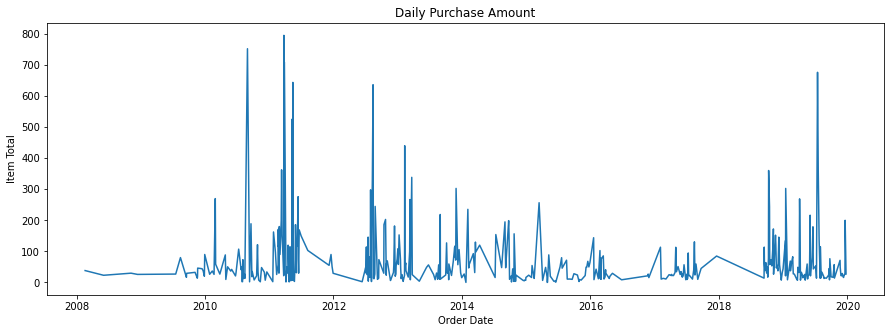

In [55]:
# Plot OrderDate & sum of purchases by date

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(df_DateTotal.index, df_DateTotal.values)
ax.set_xlabel('Order Date')
ax.set_ylabel('Item Total')
ax.set_title('Daily Purchase Amount')
plt.show()
#ax.figure.savefig('./img/DailyPurchaseAmount.png', bbox_inches='tight', dpi=150)

In [56]:
# Use groupby to sum taxes by date

df_DateTax = df[['OrderDate', 'Tax']]
df_DateTax = df_DateTax.groupby('OrderDate')
df_DateTax = df_DateTax['Tax'].sum()
df_DateTax

OrderDate
2008-02-19    0.00
2008-06-03    0.00
2008-11-06    0.00
2008-12-13    0.00
2009-07-18    0.00
              ... 
2019-12-13    1.46
2019-12-14    1.45
2019-12-18    1.79
2019-12-19    0.00
2019-12-24    0.00
Name: Tax, Length: 445, dtype: float64

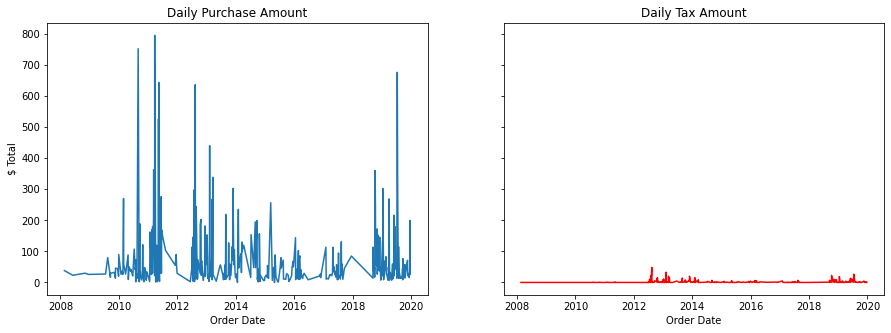

In [59]:
# Plot OrderDate and ItemTotal and OrderDate and PurchasePricePerUnit

fig, ax = plt.subplots(1,2, sharey = True, figsize = (15,5))

ax[0].plot(df_DateTotal.index, df_DateTotal.values)
ax[1].plot(df_DateTax.index, df_DateTax.values, color = 'red')

ax[0].set_xlabel('Order Date')
ax[0].set_ylabel('$ Total')
ax[1].set_xlabel('Order Date')

ax[0].set_title('Daily Purchase Amount')
ax[1].set_title('Daily Tax Amount')

plt.show()

In [62]:
# The previous graphs contained too much data since they were being plotted for each day. 
# Grouping will allow the information to be more legible.

# Purchases by Year 

df_OrderYear = df[['OrderDate', 'ItemTotal', 'OrderYear']]
df_OrderYear = df_OrderYear.sort_values('OrderDate')
df_OrderYear = df_OrderYear.groupby('OrderYear')
df_OrderYear = df_OrderYear['ItemTotal'].sum()
df_OrderYear

OrderYear
2008     117.09
2009     456.85
2010    2421.77
2011    7176.93
2012    3651.85
2013    3689.19
2014    2075.99
2015    1257.52
2016     823.48
2017    1392.77
2018    2689.12
2019    4604.85
Name: ItemTotal, dtype: float64

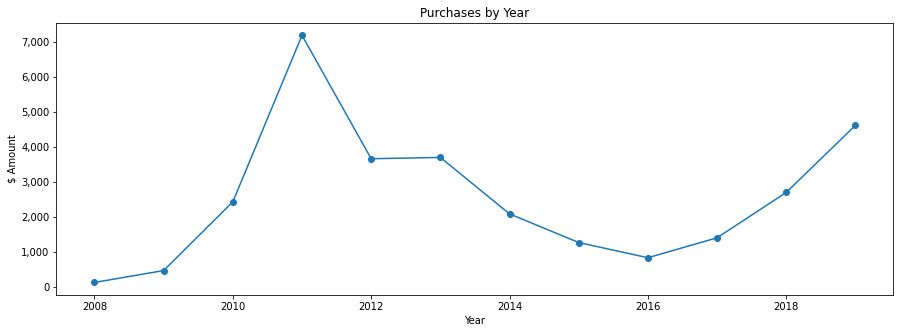

In [66]:
fig,ax = plt.subplots(figsize = (15,5))
ax.plot(df_OrderYear.index, df_OrderYear.values, marker = 'o')
ax.set_title('Purchases by Year')

# x-axis
ax.set_xlabel('Year')

# y-axis
ax.set_ylabel('$ Amount')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,p: format(int(y), ','))
)  

plt.show()

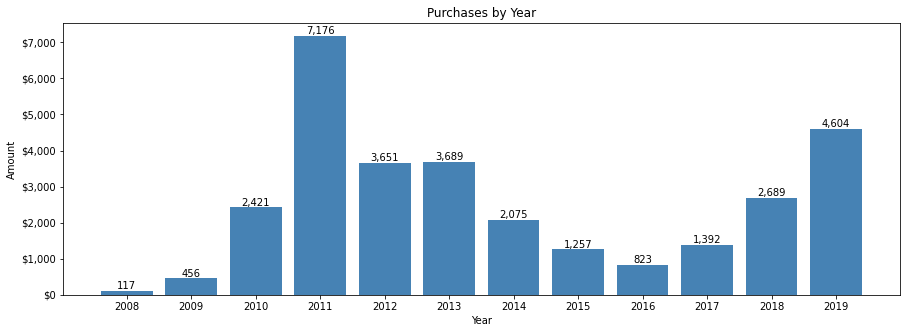

In [69]:
fig,ax = plt.subplots(figsize = (15,5))
ax.bar(df_OrderYear.index, df_OrderYear.values, color = 'steelblue')
ax.set_title('Purchases by Year')

# x-axis
ax.set_xlabel('Year')
plt.xticks([x for x in df_OrderYear.index], rotation = 0)

# y-axis
ax.set_ylabel('Amount')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,p: '$'+format(int(y), ','))
)

# labels
for i,j in zip(df_OrderYear.index, df_OrderYear.values):
    ax.annotate(format(int(j), ','), xy=(i,j), va='bottom', ha='center')

plt.show()
#ax.figure.savefig('./img/PurchasesByYear.png', bbox_inches='tight', dpi=150)

In [71]:
# Purchases by Month

df_OrderMonth = df[['OrderDate', 'ItemTotal', 'OrderMonth']]
df_OrderMonth = df_OrderMonth.sort_values('OrderDate')
df_OrderMonth = df_OrderMonth.groupby('OrderMonth')
df_OrderMonth = df_OrderMonth['ItemTotal'].sum()
df_OrderMonth

OrderMonth
1     1435.93
2     3082.08
3     4439.17
4     1497.22
5     2198.31
6     2042.64
7     3352.54
8     3507.65
9     1887.06
10    2392.95
11    2187.99
12    2333.87
Name: ItemTotal, dtype: float64

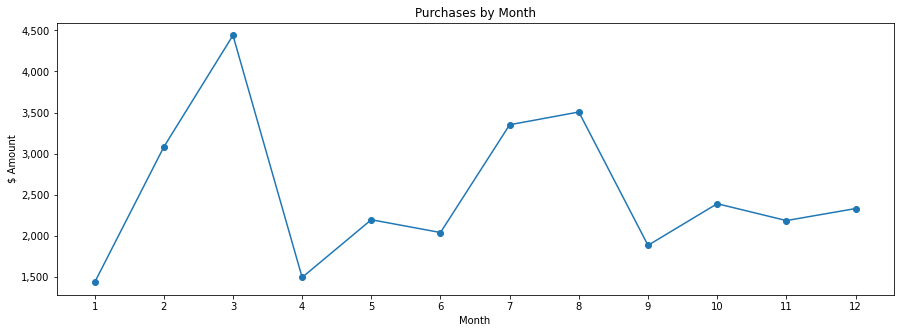

In [72]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(df_OrderMonth.index, df_OrderMonth.values, marker = 'o')
ax.set_title('Purchases by Month')

# x-axis
ax.set_xlabel('Month')
plt.xticks([x for x in df_OrderMonth.index])

# y-axis
ax.set_ylabel('$ Amount')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,p: format(int(y), ','))
)

plt.show()

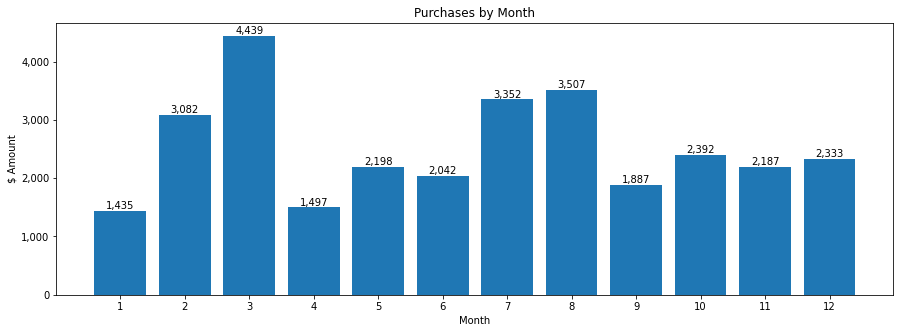

In [80]:
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(df_OrderMonth.index, df_OrderMonth.values)
ax.set_title('Purchases by Month')

# x-axis
ax.set_xlabel('Month')
plt.xticks([x for x in df_OrderMonth.index])

# y-axis
ax.set_ylabel('$ Amount')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,p: format(int(y), ','))
)

# labels
for i,j in zip(df_OrderMonth.index, df_OrderMonth.values):
    ax.annotate(format(int(j), ','), xy=(i,j), va='bottom', ha='center')

plt.show()

In [77]:
# Add month names

df_OrderMonthName = df[['OrderDate', 'OrderMonth', 'ItemTotal']]
df_OrderMonthName = df_OrderMonthName.sort_values('OrderDate')
df_OrderMonthName = df_OrderMonthName.groupby('OrderMonth', as_index=False)
df_OrderMonthName = df_OrderMonthName['ItemTotal'].sum()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df_OrderMonthName['MonthName'] = months
df_OrderMonthName

,OrderMonth,ItemTotal,MonthName
0,1,1435.93,Jan
1,2,3082.08,Feb
2,3,4439.17,Mar
3,4,1497.22,Apr
4,5,2198.31,May
5,6,2042.64,Jun
6,7,3352.54,Jul
7,8,3507.65,Aug
8,9,1887.06,Sep
9,10,2392.95,Oct


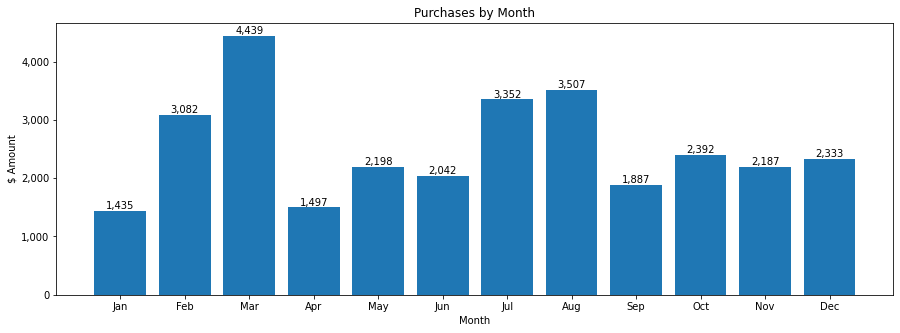

In [82]:
fig,ax = plt.subplots(figsize = (15,5))
ax.bar(df_OrderMonthName.MonthName, df_OrderMonthName.ItemTotal)
ax.set_title('Purchases by Month')

# x-axis
ax.set_xlabel('Month')
plt.xticks([x for x in df_OrderMonthName.MonthName])

# y-axis
ax.set_ylabel('$ Amount')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,p: format(int(y), ','))
)

# labels
for i,j in zip(df_OrderMonthName.MonthName, df_OrderMonthName.ItemTotal):
    ax.annotate(format(int(j), ','), xy=(i,j), va='bottom', ha='center')

plt.show()
#ax.figure.savefig('./img/PurchasesByMonth.png', bbox_inches='tight', dpi=150)

In [85]:
# Transactions by Year

df_TransYear = df[['OrderDate', 'ItemTotal', 'OrderYear']]
df_TransYear = df_TransYear.groupby('OrderYear')
df_TransYear = df_TransYear['ItemTotal'].size()
df_TransYear

OrderYear
2008      9
2009     15
2010     83
2011     96
2012     96
2013     89
2014     48
2015     59
2016     36
2017     68
2018     69
2019    113
Name: ItemTotal, dtype: int64

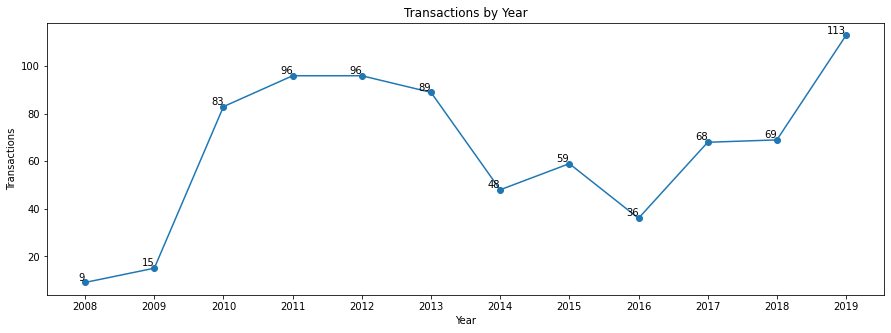

In [98]:
fig,ax = plt.subplots(figsize = (15,5))
ax.plot(df_TransYear.index, df_TransYear.values, marker = 'o')
ax.set_title('Transactions by Year')

# x-axis
ax.set_xlabel('Year')
plt.xticks([x for x in df_TransYear.index])

# y-axis
ax.set_ylabel('Transactions')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,p: format(int(y), ','))
)

# labels
for i,j in zip(df_TransYear.index, df_TransYear.values):
    ax.annotate(format(int(j)), xy=(i,j), va='bottom', ha='right')

plt.show()
#ax.figure.savefig('./img/TransactionsByYear.png', bbox_inches='tight', dpi=150)

In [99]:
# Transactions by Seller

df_TransSeller = df[['Seller']]
df_TransSeller = df_TransSeller.groupby(df_TransSeller['Seller'] == 'Amazon')
df_TransSeller = df_TransSeller.size()
df_TransSeller

Seller
False    329
True     452
dtype: int64

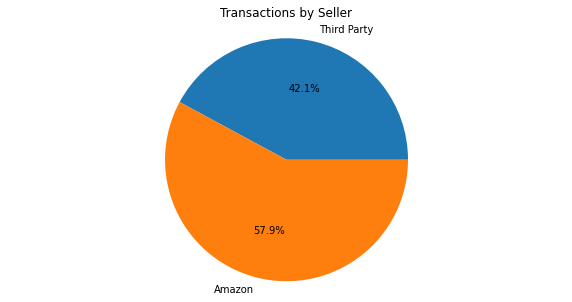

In [100]:
fig,ax = plt.subplots(figsize = (10,5))
ax.pie(df_TransSeller.values, labels = ['Third Party', 'Amazon'], autopct = '%1.1f%%')
ax.set_title('Transactions by Seller')
ax.axis('equal')
plt.show()

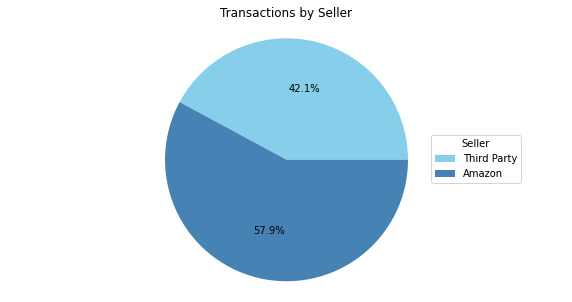

In [113]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(df_TransSeller.values, autopct = '%1.1f%%', colors = ['skyblue', 'steelblue'])
ax.legend(
    #df_TransSeller.index,
    title = 'Seller',
    labels = ['Third Party', 'Amazon'],
    loc = 'center left',
    bbox_to_anchor = (0.75,0,0.5,1)
)
ax.set_title('Transactions by Seller')
ax.axis('equal')
plt.show()
#ax.figure.savefig('./img/TransactionsBySeller.png', bbox_inches='tight', dpi=150)

In [106]:
# Purchases by Seller

df_PurchasesSeller = df[['Seller', 'ItemTotal']]
df_PurchasesSeller = df_PurchasesSeller.groupby(df_PurchasesSeller['Seller'] == 'Amazon')
df_PurchasesSeller = df_PurchasesSeller['ItemTotal'].sum()
df_PurchasesSeller

Seller
False     7575.08
True     22782.33
Name: ItemTotal, dtype: float64

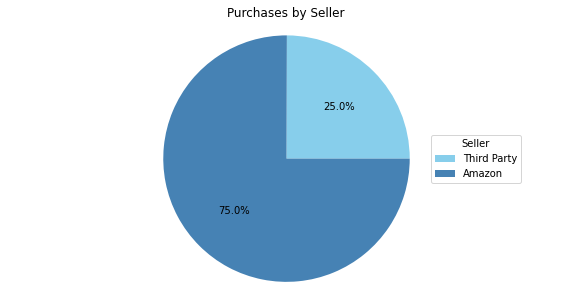

In [111]:
fig,ax = plt.subplots(figsize = (10,5))
ax.pie(df_PurchasesSeller.values, autopct = '%1.1f%%', colors = ['skyblue', 'steelblue'])
ax.legend(
    #df_PurchasesSeller.index,
    title = 'Seller',
    labels = ['Third Party', 'Amazon'],
    loc = 'center left',
    bbox_to_anchor = (0.75,0,0.5,1)    
)
ax.set_title('Purchases by Seller')
ax.axis('equal')
plt.show()
#ax.figure.savefig('./img/PurchasesBySeller.png', bbox_inches='tight', dpi=150)

In [128]:
# Purchases by Category
# Note: it is necessary to sort by reverse in the df so the plot can be arranged alphabetically
# from top to bottom

df_CategoryTotal = df[['Category', 'ItemTotal']]
df_CategoryTotal['Category'] = df_CategoryTotal['Category'].str.replace('_', ' & ').str.title()
df_CategoryTotal['Category'].loc[df_CategoryTotal['Category'] == 'Gift & Card'] = 'Gift Card'
#df_CategoryTotal['Category'] = df_CategoryTotal['Category'].str.replace('Gift & Card', 'Gift Card')
df_CategoryTotal = df_CategoryTotal.groupby('Category')
df_CategoryTotal = df_CategoryTotal['ItemTotal'].sum()
df_CategoryTotal = df_CategoryTotal.sort_index(ascending = False)
df_CategoryTotal

<ipython-input-128-7afe33374e98>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CategoryTotal['Category'] = df_CategoryTotal['Category'].str.replace('_', ' & ').str.title()
<ipython-input-128-7afe33374e98>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CategoryTotal['Category'].loc[df_CategoryTotal['Category'] == 'Gift & Card'] = 'Gift Card'


Category
Unknown              2092.30
Tools                 533.80
Sports & Outdoor      831.09
Other                 842.15
Office                504.44
Home                 2215.82
Health & Beauty      3059.04
Grocery               481.91
Gift Card             638.92
Entertainment          61.16
Electronics          4208.20
Computer            10519.35
Books                1519.07
Apparel              2850.16
Name: ItemTotal, dtype: float64

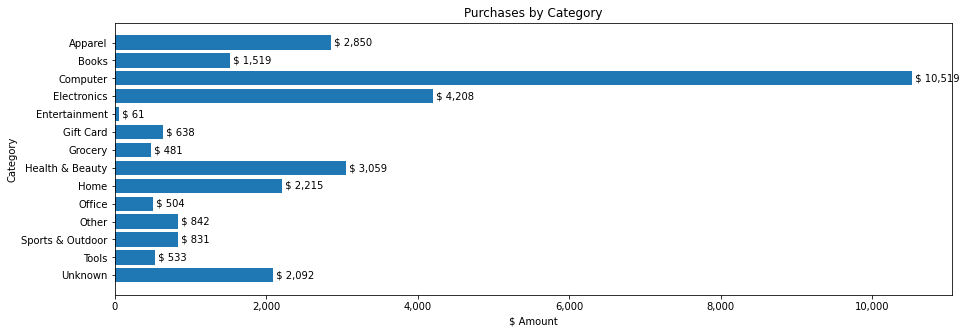

In [130]:
# Plot purchases by category

fig,ax = plt.subplots(figsize = (15,5))
ax.barh(df_CategoryTotal.index, df_CategoryTotal.values)
ax.set_title('Purchases by Category')

# x-axis
ax.set_xlabel('$ Amount')
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x,p: format(int(x), ','))
)

# y-axis
ax.set_ylabel('Category')

# labels
for i,j in zip(df_CategoryTotal.index, df_CategoryTotal.values):
    ax.annotate(' $ '+format(int(j), ','), xy=(j,i), va='center', ha='left')

plt.show()
#ax.figure.savefig('./img/PurchasesByCategory.png', bbox_inches='tight', dpi=150)

In [30]:
# Purchases by category share

df_CategoryShare = df[['Category', 'ItemTotal']]
df_CategoryShare = df_CategoryShare.groupby('Category', as_index = False)
df_CategoryShare = df_CategoryShare['ItemTotal'].sum()
df_CategoryShare['Share'] = df_CategoryShare['ItemTotal'].div(df_CategoryShare['ItemTotal'].sum())*100
df_CategoryShare = df_CategoryShare.sort_values('Category', ascending = False)
df_CategoryShare

,Category,ItemTotal,Share
13,UNKNOWN,2092.30,6.892222
12,TOOLS,533.80,1.758385
11,SPORTS_OUTDOOR,831.09,2.737684
10,OTHER,842.15,2.774117
9,OFFICE,504.44,1.661670
8,HOME,2215.82,7.299108
7,HEALTH_BEAUTY,3059.04,10.076749
6,GROCERY,481.91,1.587454
5,GIFT_CARD,638.92,2.104659
4,ENTERTAINMENT,61.16,0.201466


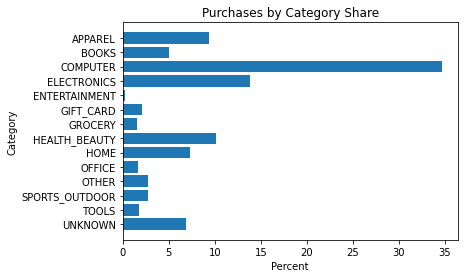

In [31]:
# Plot purchases by category share

fig,ax = plt.subplots()
ax.barh(df_CategoryShare['Category'],df_CategoryShare['Share'])
ax.set_xlabel('Percent')
ax.set_ylabel('Category')
ax.set_title('Purchases by Category Share')
plt.show()
#ax.figure.savefig('./img/PurchasesByCategoryShare.png', bbox_inches='tight', dpi=150)

In [32]:
# Purchases by day of week

df_DayPur = df[['OrderDayIndex','OrderDayName','ItemTotal']]
df_DayPur = df_DayPur.groupby(['OrderDayName','OrderDayIndex'], as_index = False)
df_DayPur = df_DayPur['ItemTotal'].sum()
df_DayPur = df_DayPur.sort_values('OrderDayIndex')
df_DayPur

,OrderDayName,OrderDayIndex,ItemTotal
1,Monday,0,6787.06
5,Tuesday,1,4378.23
6,Wednesday,2,3476.16
4,Thursday,3,4260.84
0,Friday,4,4073.42
2,Saturday,5,2965.26
3,Sunday,6,4416.44


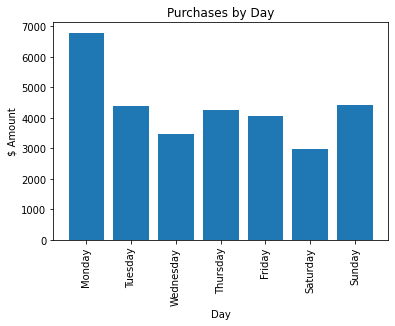

In [33]:
# Plot purchases by day of week

fig,ax = plt.subplots()
ax.bar(df_DayPur['OrderDayName'],df_DayPur['ItemTotal'])
ax.set_xlabel('Day')
ax.set_ylabel('$ Amount')
ax.set_title('Purchases by Day')
plt.xticks(rotation = 90)
plt.show()
#ax.figure.savefig('./img/PurchasesByDay.png', bbox_inches='tight', dpi=150)

In [34]:
# Avg transaction value by year

df_YearAvgTrans = df[['OrderYear','ItemTotal']]
df_YearAvgTrans = df_YearAvgTrans.groupby(['OrderYear'], as_index = False)
df_YearAvgTrans = df_YearAvgTrans['ItemTotal'].sum()
df_YearAvgTrans

,OrderYear,ItemTotal
0,2008,117.09
1,2009,456.85
2,2010,2421.77
3,2011,7176.93
4,2012,3651.85
5,2013,3689.19
6,2014,2075.99
7,2015,1257.52
8,2016,823.48
9,2017,1392.77


In [35]:
df_NumTransYear = df[['OrderYear', 'OrderID']].groupby('OrderYear').size()
df_NumTransYear

OrderYear
2008      9
2009     15
2010     83
2011     96
2012     96
2013     89
2014     48
2015     59
2016     36
2017     68
2018     69
2019    113
dtype: int64

In [36]:
df_YearAvgTrans['Trans'] = df_NumTransYear.values
df_YearAvgTrans

,OrderYear,ItemTotal,Trans
0,2008,117.09,9
1,2009,456.85,15
2,2010,2421.77,83
3,2011,7176.93,96
4,2012,3651.85,96
5,2013,3689.19,89
6,2014,2075.99,48
7,2015,1257.52,59
8,2016,823.48,36
9,2017,1392.77,68


In [37]:
df_YearAvgTrans['AvgPerTrans'] = df_YearAvgTrans['ItemTotal'].div(df_YearAvgTrans['Trans'])
df_YearAvgTrans

,OrderYear,ItemTotal,Trans,AvgPerTrans
0,2008,117.09,9,13.010000
1,2009,456.85,15,30.456667
2,2010,2421.77,83,29.177952
3,2011,7176.93,96,74.759687
4,2012,3651.85,96,38.040104
5,2013,3689.19,89,41.451573
6,2014,2075.99,48,43.249792
7,2015,1257.52,59,21.313898
8,2016,823.48,36,22.874444
9,2017,1392.77,68,20.481912


In [38]:
# All of the above can be done more quickly using the following:

#df_YearAvgTrans = df[['OrderYear','ItemTotal']]
#df_YearAvgTrans = df_YearAvgTrans.groupby(['OrderYear'], as_index = False)['ItemTotal'].sum()

#df_YearOrders = df[['OrderYear','ItemTotal']].groupby('OrderYear')['ItemTotal'].size()
#df_YearAvgTrans['Trans'] = df_YearOrders.values

#df_YearAvgTrans['AvgTrans'] = df_YearAvgTrans['ItemTotal'].div(df_YearAvgTrans['Trans'])
#df_YearAvgTrans

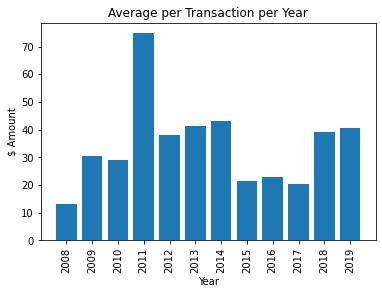

In [39]:
# Plot average per transaction by year

fig, ax = plt.subplots()
ax.bar(df_YearAvgTrans['OrderYear'],df_YearAvgTrans['AvgPerTrans'])
ax.set_xlabel('Year')
ax.set_ylabel('$ Amount')
ax.set_title('Average per Transaction per Year')
plt.xticks([x for x in df_YearAvgTrans['OrderYear']], rotation = 90)
plt.show()
#ax.figure.savefig('./img/AveragePerTransPerYear.png', bbox_inches='tight', dpi=150)

In [40]:
# Shipping method

df_Carriers = df['Carrier']
CarrierVC = df_Carriers.value_counts()
CarrierVC = CarrierVC.sort_index(ascending = False)
CarrierVC

USPS                    273
UPS Mail Innovations      5
UPS                     170
Other                    98
FedEx SmartPost           4
FedEx                    22
DHL                       9
AMZN                    200
Name: Carrier, dtype: int64

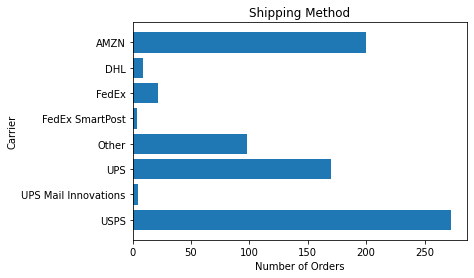

In [41]:
# Plot of shipping method

fig,ax = plt.subplots()
ax.barh(CarrierVC.index, CarrierVC.values)
ax.set_xlabel('Number of Orders')
ax.set_ylabel('Carrier')
ax.set_title('Shipping Method')
plt.show()
#ax.figure.savefig('./img/ShippingMethod.png', bbox_inches='tight', dpi=150)

In [42]:
# Shipping method and avg transaction cost

df_CarrierTotal = df[['Carrier', 'ItemTotal']]
df_CarrierTotal = df_CarrierTotal.groupby('Carrier', as_index = False)['ItemTotal'].sum()

df_CarrierTrans = df[['Carrier', 'ItemTotal']].groupby('Carrier')['ItemTotal'].size()
df_CarrierTotal['NumTrans'] = df_CarrierTrans.values

df_CarrierTotal['AvgPerTrans'] = df_CarrierTotal['ItemTotal'].div(df_CarrierTotal['NumTrans']).round(2)

df_CarrierTotal = df_CarrierTotal.sort_values('Carrier', ascending = False)
df_CarrierTotal

,Carrier,ItemTotal,NumTrans,AvgPerTrans
7,USPS,6594.03,273,24.15
6,UPS Mail Innovations,57.62,5,11.52
5,UPS,10874.11,170,63.97
4,Other,4113.09,98,41.97
3,FedEx SmartPost,100.26,4,25.06
2,FedEx,1948.20,22,88.55
1,DHL,89.71,9,9.97
0,AMZN,6580.39,200,32.90


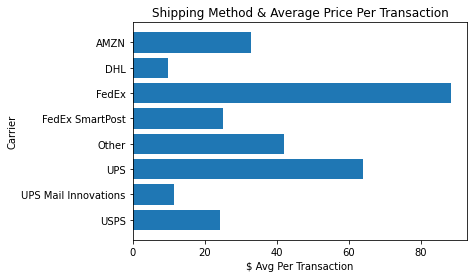

In [43]:
# Plot shipping method and avg transaction cost

fig,ax = plt.subplots()
ax.barh(df_CarrierTotal['Carrier'], df_CarrierTotal['AvgPerTrans'])
ax.set_xlabel('$ Avg Per Transaction')
ax.set_ylabel('Carrier')
ax.set_title('Shipping Method & Average Price Per Transaction')
plt.show()
#ax.figure.savefig('./img/ShippingMethodPrice.png', bbox_inches='tight', dpi=150)